In [1]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'
import mne
from mne.preprocessing import ICA
from mne_bids import BIDSPath, read_raw_bids

In [2]:
eeg_data_train = np.load('../data/things-eeg2_preproc/preprocessed_eeg_training.npy', allow_pickle=True).item()
eeg_data_test = np.load('../data/things-eeg2_preproc/preprocessed_eeg_test.npy', allow_pickle=True).item()
train_thingseeg2_avg = eeg_data_train['preprocessed_eeg_data'].mean(1)[:,:,20:] * 1e-6
test_thingseeg2_avg = eeg_data_test['preprocessed_eeg_data'].mean(1)[:,:,20:] * 1e-6

print('Training EEG data shape:')
print(eeg_data_train['preprocessed_eeg_data'].shape)
print('(Training image conditions × Training EEG repetitions × EEG channels × '
    'EEG time points)')

print('\nTest EEG data shape:')
print(eeg_data_test['preprocessed_eeg_data'].shape)
print('(Test image conditions × Test EEG repetitions × EEG channels × '
    'EEG time points)')

Training EEG data shape:
(16540, 4, 17, 100)
(Training image conditions × Training EEG repetitions × EEG channels × EEG time points)

Test EEG data shape:
(200, 80, 17, 100)
(Test image conditions × Test EEG repetitions × EEG channels × EEG time points)


In [3]:
mne_info = mne.create_info(eeg_data_test['ch_names'], 100, 'eeg')
test_epochs = mne.EpochsArray(test_thingseeg2_avg, mne_info)

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


In [4]:
data_dir = '../data/thingseeg2/raw_bids/'
eeg_path = BIDSPath(
        subject='01',
        session='01',
        task='test',
        root=data_dir,
        datatype="eeg",
    )
raw = read_raw_bids(eeg_path, verbose='ERROR')

In [5]:
ch_pos = dict([item for item in raw.get_montage().get_positions()['ch_pos'].items() if item[0] in eeg_data_test['ch_names']])

In [6]:
dig_montage = mne.channels.make_dig_montage(ch_pos=ch_pos, nasion=raw.get_montage().get_positions()['nasion'], lpa=raw.get_montage().get_positions()['lpa'], rpa=raw.get_montage().get_positions()['rpa'])

In [7]:
test_epochs.set_montage(dig_montage)

<EpochsArray |  200 events (all good), 0 – 0.79 s, baseline off, ~2.1 MB, data loaded,
 '1': 200>

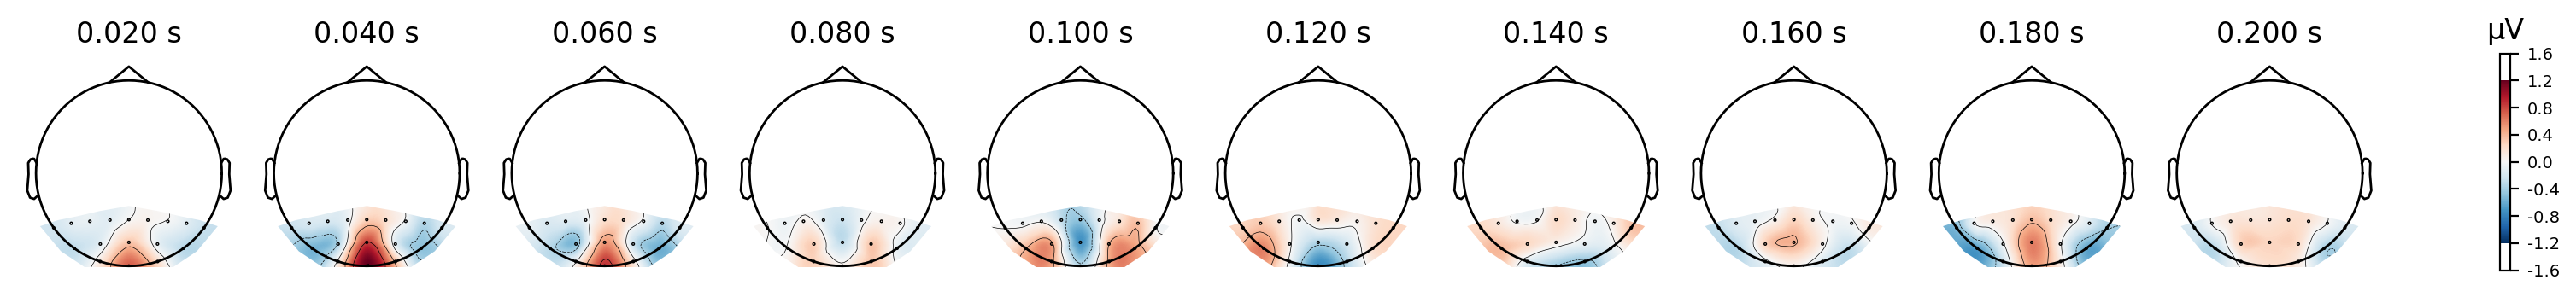

In [8]:
# test_epochs[0].average().plot();
# test_epochs.plot_sensors(show_names=True, ch_type='eeg', title='EEG sensors', show=True);
# test_epochs[0].average().plot_topomap(times=[0.1, 0.2, 0.3, 0.4, 0.5], show=True);
test_epochs[7].average().plot_topomap(times=[0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2], extrapolate='local', show=True);

In [9]:
# create ica instance with defined parameters
ica = ICA(0.999999, # number of components to extract. Here we use .95 meaning...
          # ...'as many as necessary to account for 95% of data variance...
          # in a preliminary PCA'
          max_iter= 1000, # max iterations allowed for the algorithm
          random_state=1, # this is just so you can replicate my results
          method = 'infomax', # algorithm used
          fit_params=dict(extended = True) # algorithm-specific parameters ...
         )                               #...(in this case 'use extended infomax')

In [10]:
# fit ica with the parameters above to the data
ica.fit(test_epochs, # data
        picks = 'eeg', # channels to use
        # reject = dict(eeg = 300e-6) # threshold to ignore parts of the signal
       )

Fitting ICA to data using 17 channels (please be patient, this may take a while)
Selecting by explained variance: 17 components
Computing Extended Infomax ICA


/tmp/ipykernel_2612010/1168566631.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(test_epochs, # data


Fitting ICA took 5.6s.


<ICA | epochs decomposition, method: infomax (fit in 1000 iterations on 16000 samples), 17 ICA components (17 PCA components available), channel types: eeg, no sources marked for exclusion>

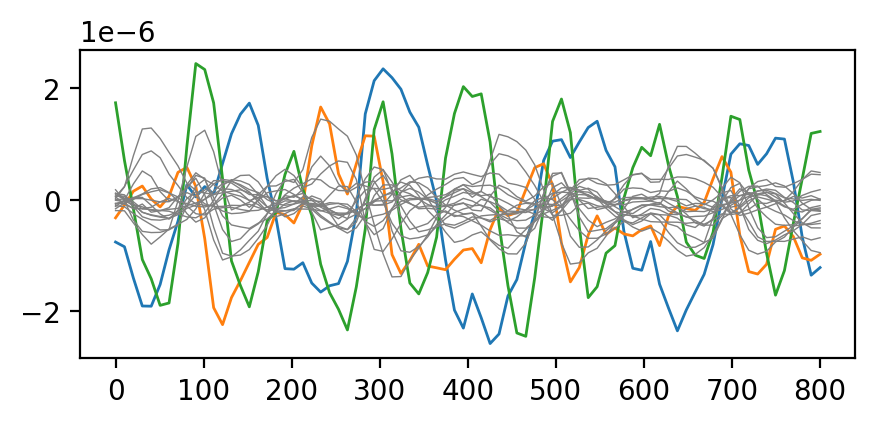

In [11]:
plt.figure(figsize=(5,2))
# ica.plot_sources(test_epochs);
# ica.plot_sources(test_epochs[0].average(), picks=0);
x = np.linspace(0, 800, 80)
plt.plot(x, ica.get_sources(test_epochs[0].average()).get_data()[0:3].T * 1e-6, lw = 1);
plt.plot(x, test_epochs[0].average().get_data().T, lw = 0.5, color="gray");
plt.show();
# test_epochs[0].average().plot();

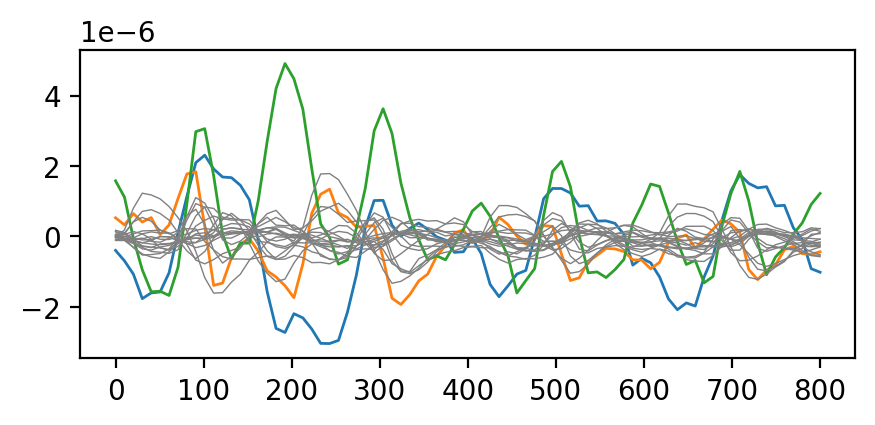

In [12]:
plt.figure(figsize=(5,2))
# ica.plot_sources(test_epochs);
# ica.plot_sources(test_epochs[0].average(), picks=0);
x = np.linspace(0, 800, 80)
plt.plot(x, ica.get_sources(test_epochs[32].average()).get_data()[0:3].T * 1e-6, lw = 1);
plt.plot(x, test_epochs[32].average().get_data().T, lw = 0.5, color="gray");
plt.show();
# test_epochs[0].average().plot();

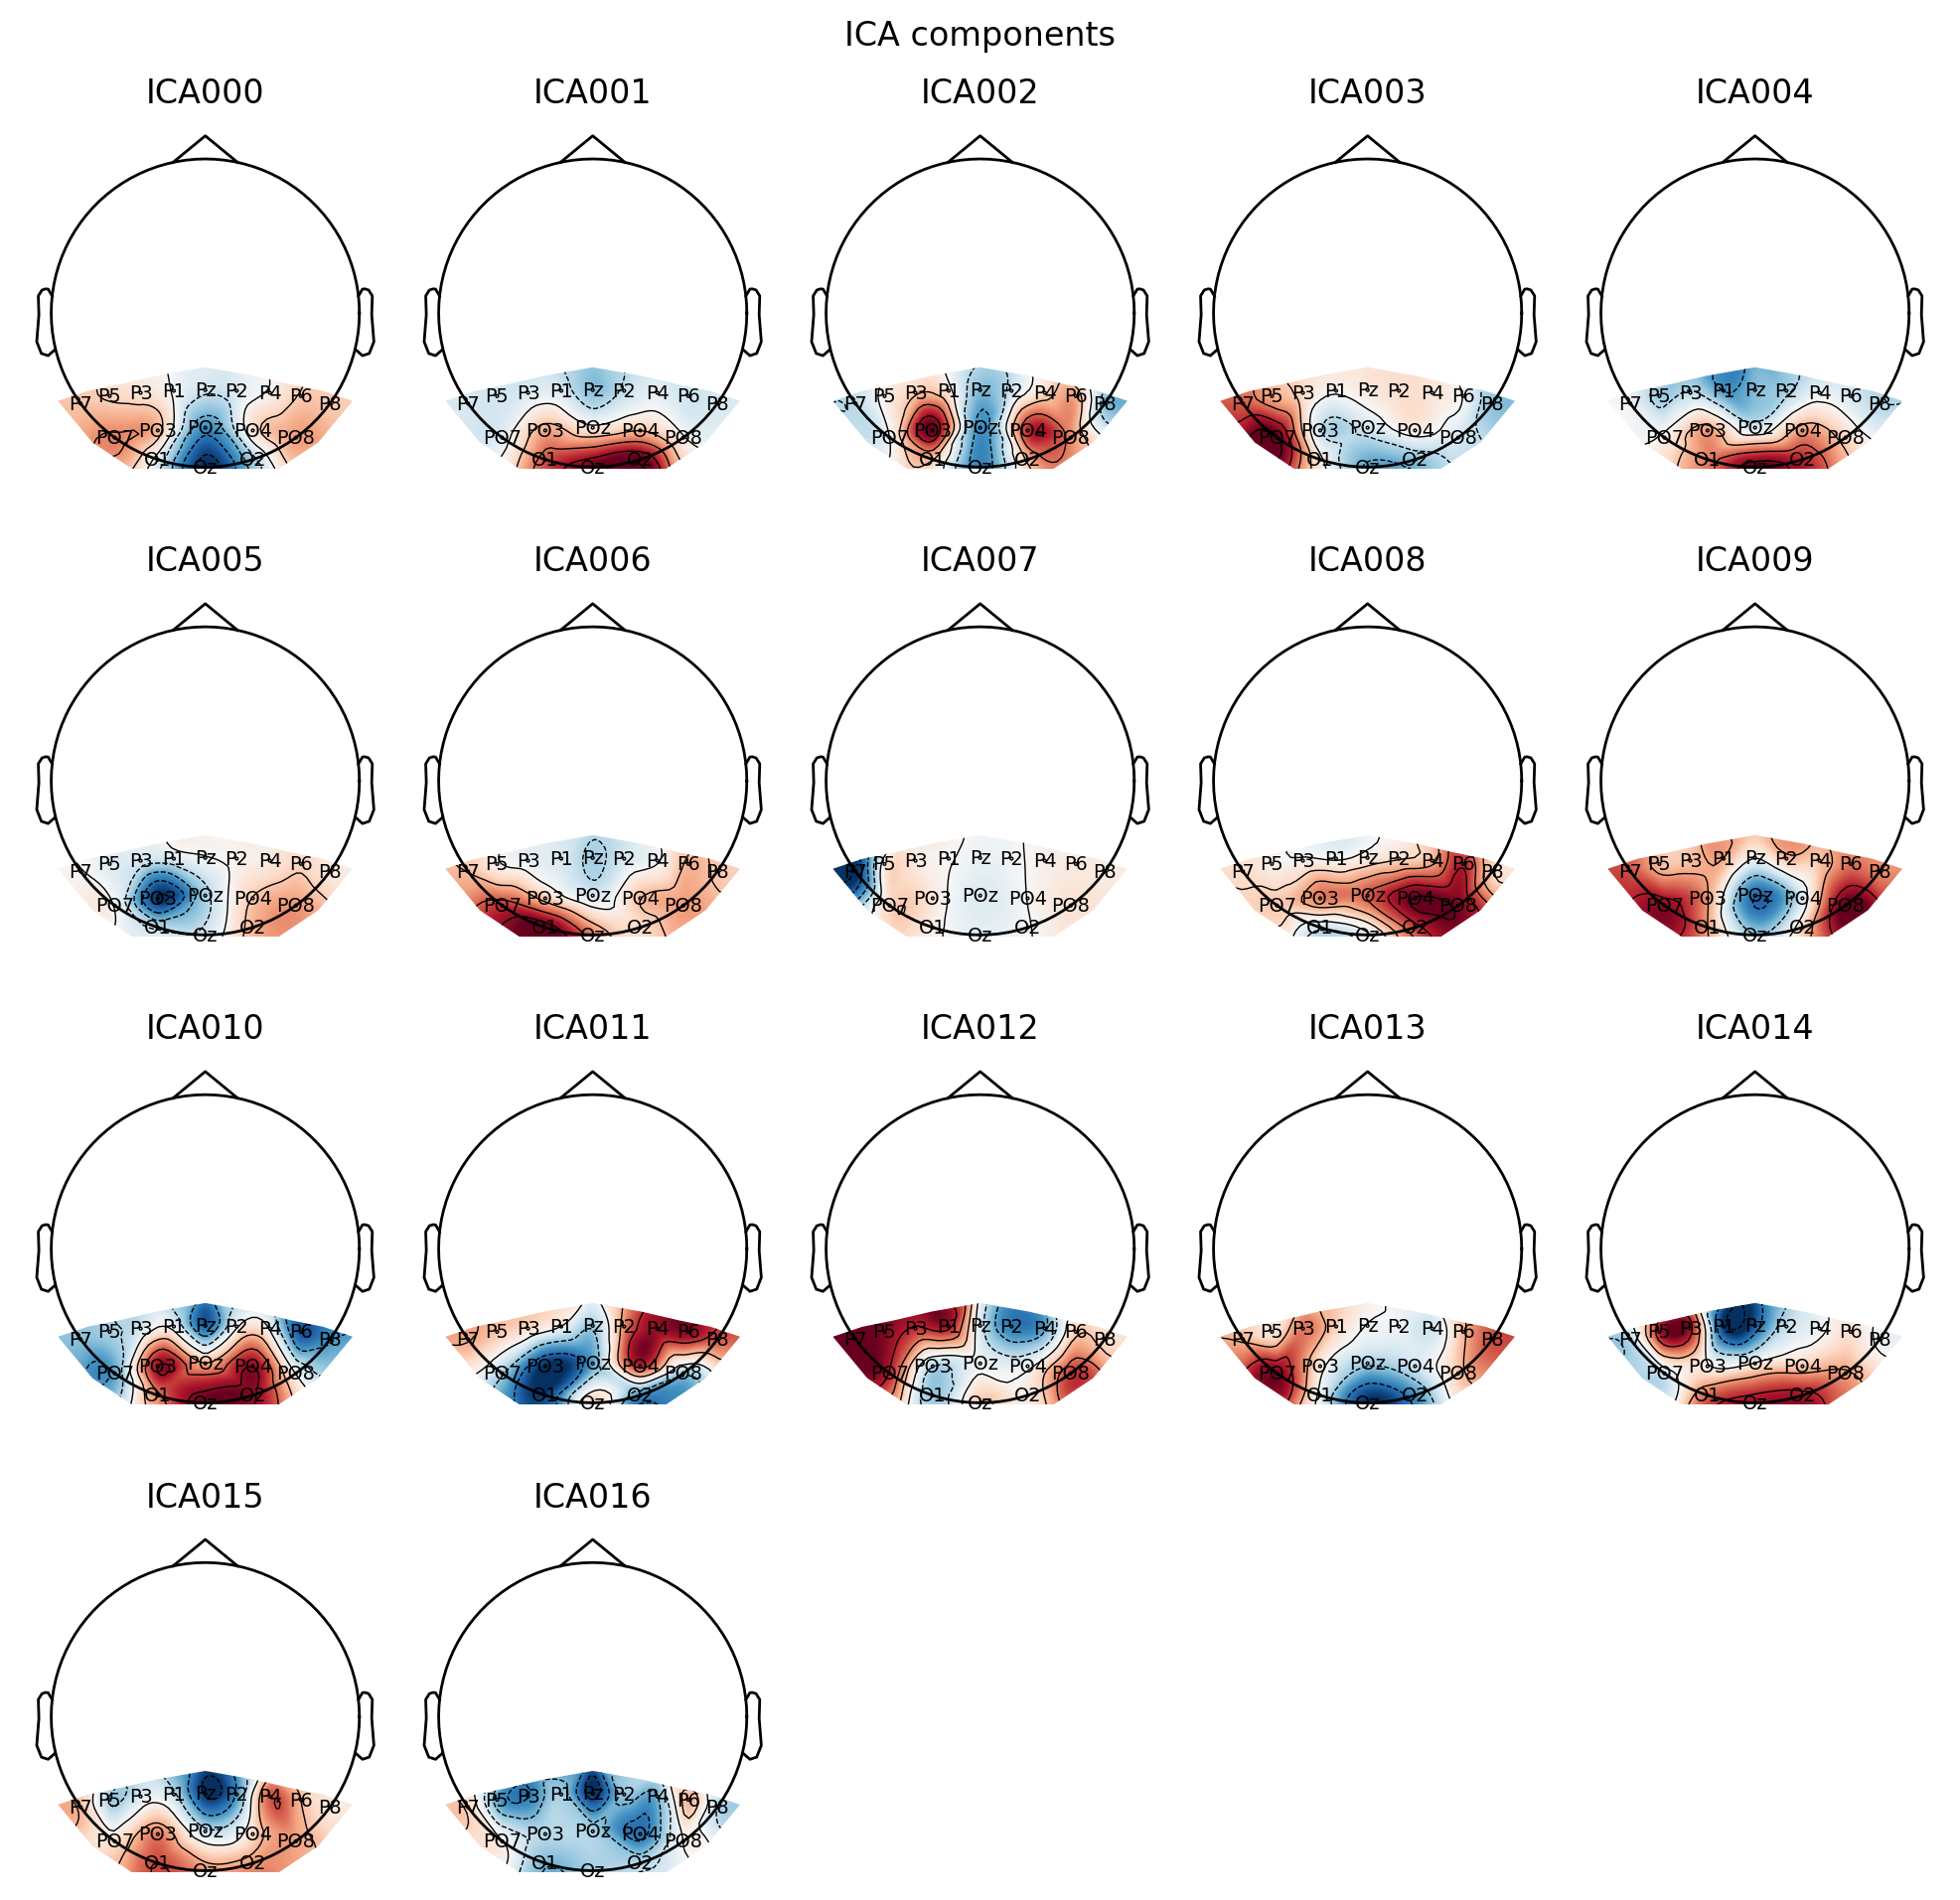

In [13]:
ica.plot_components(extrapolate='local', show_names=True);

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


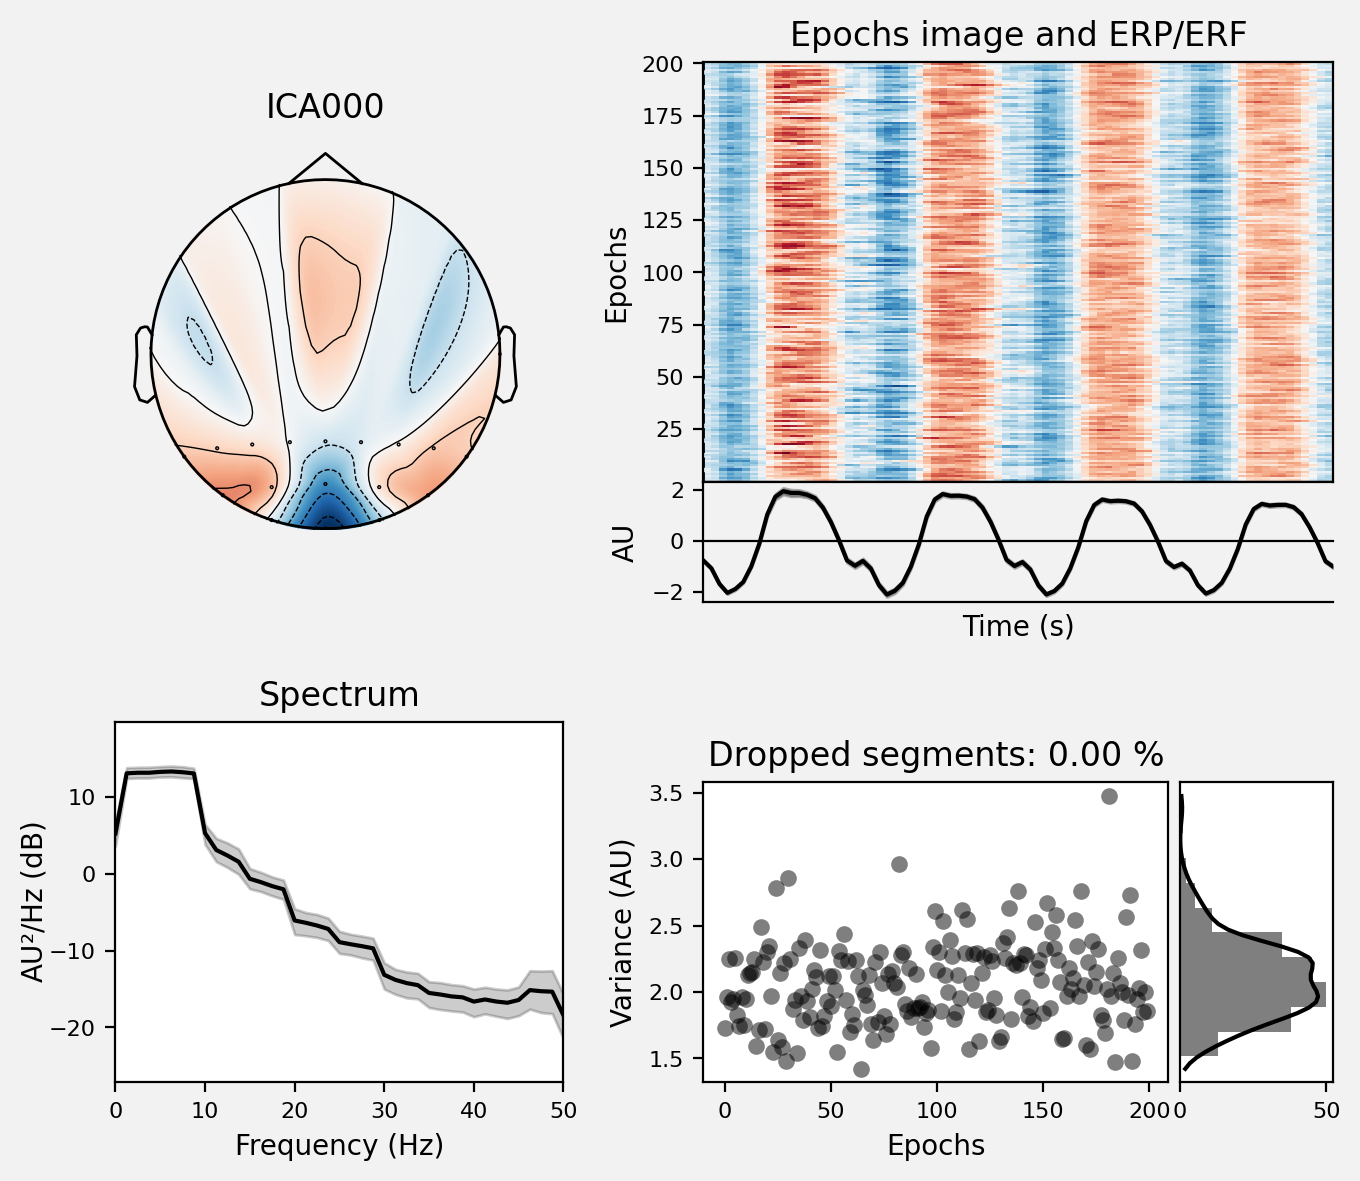

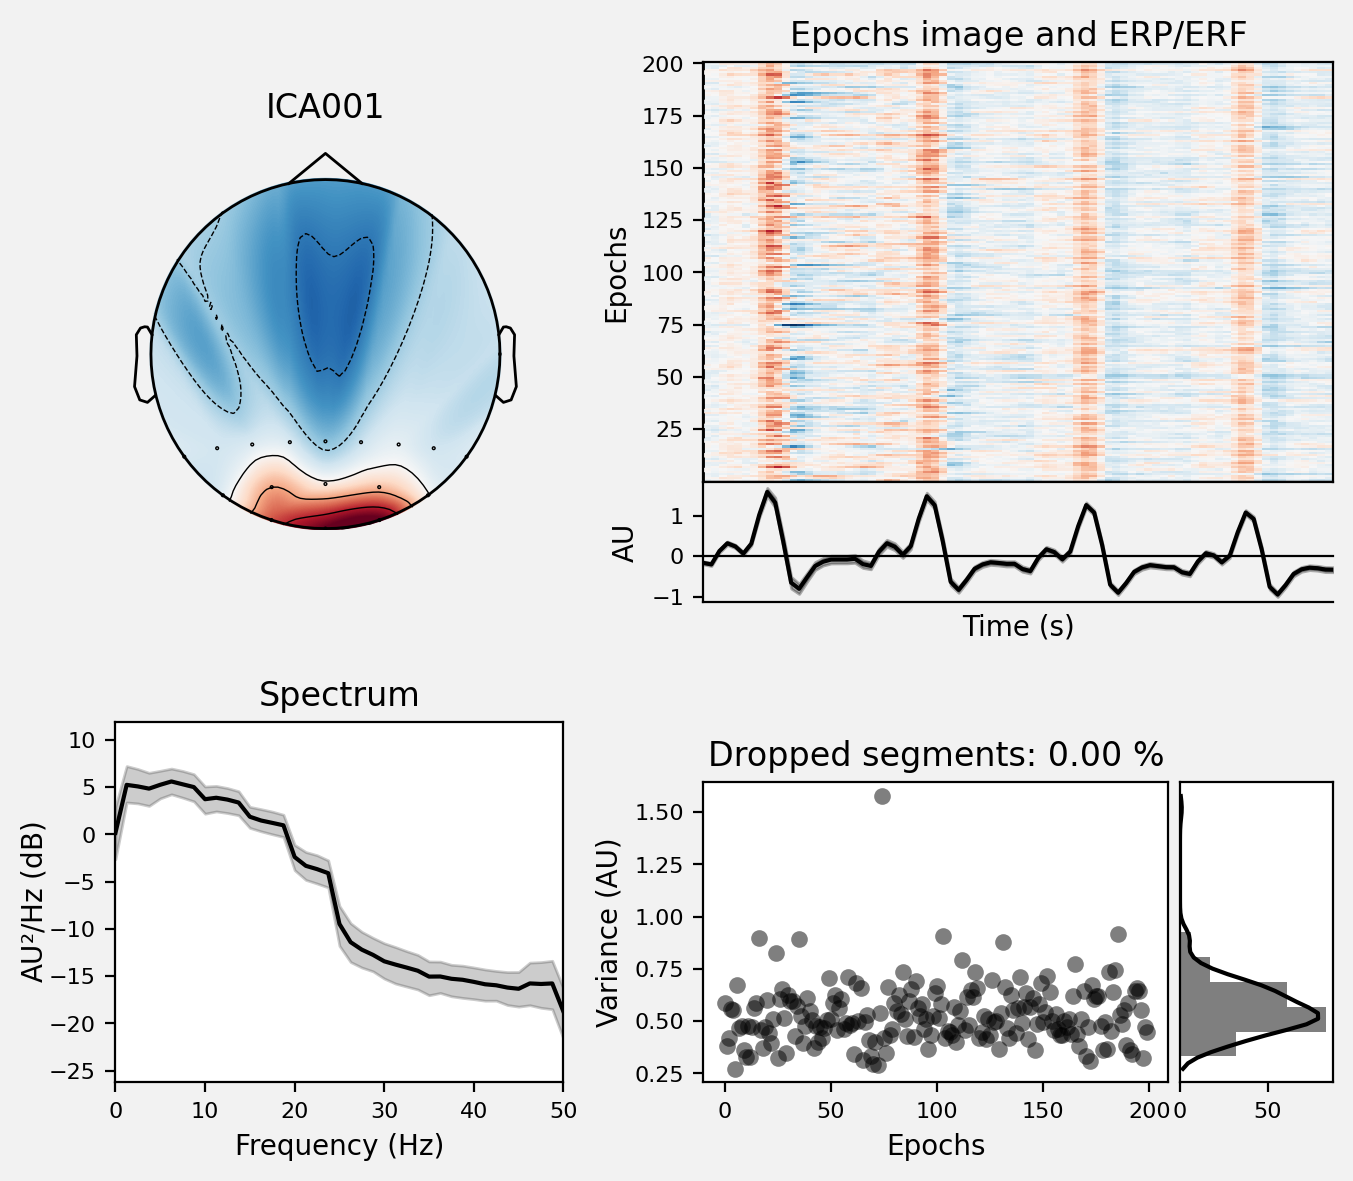

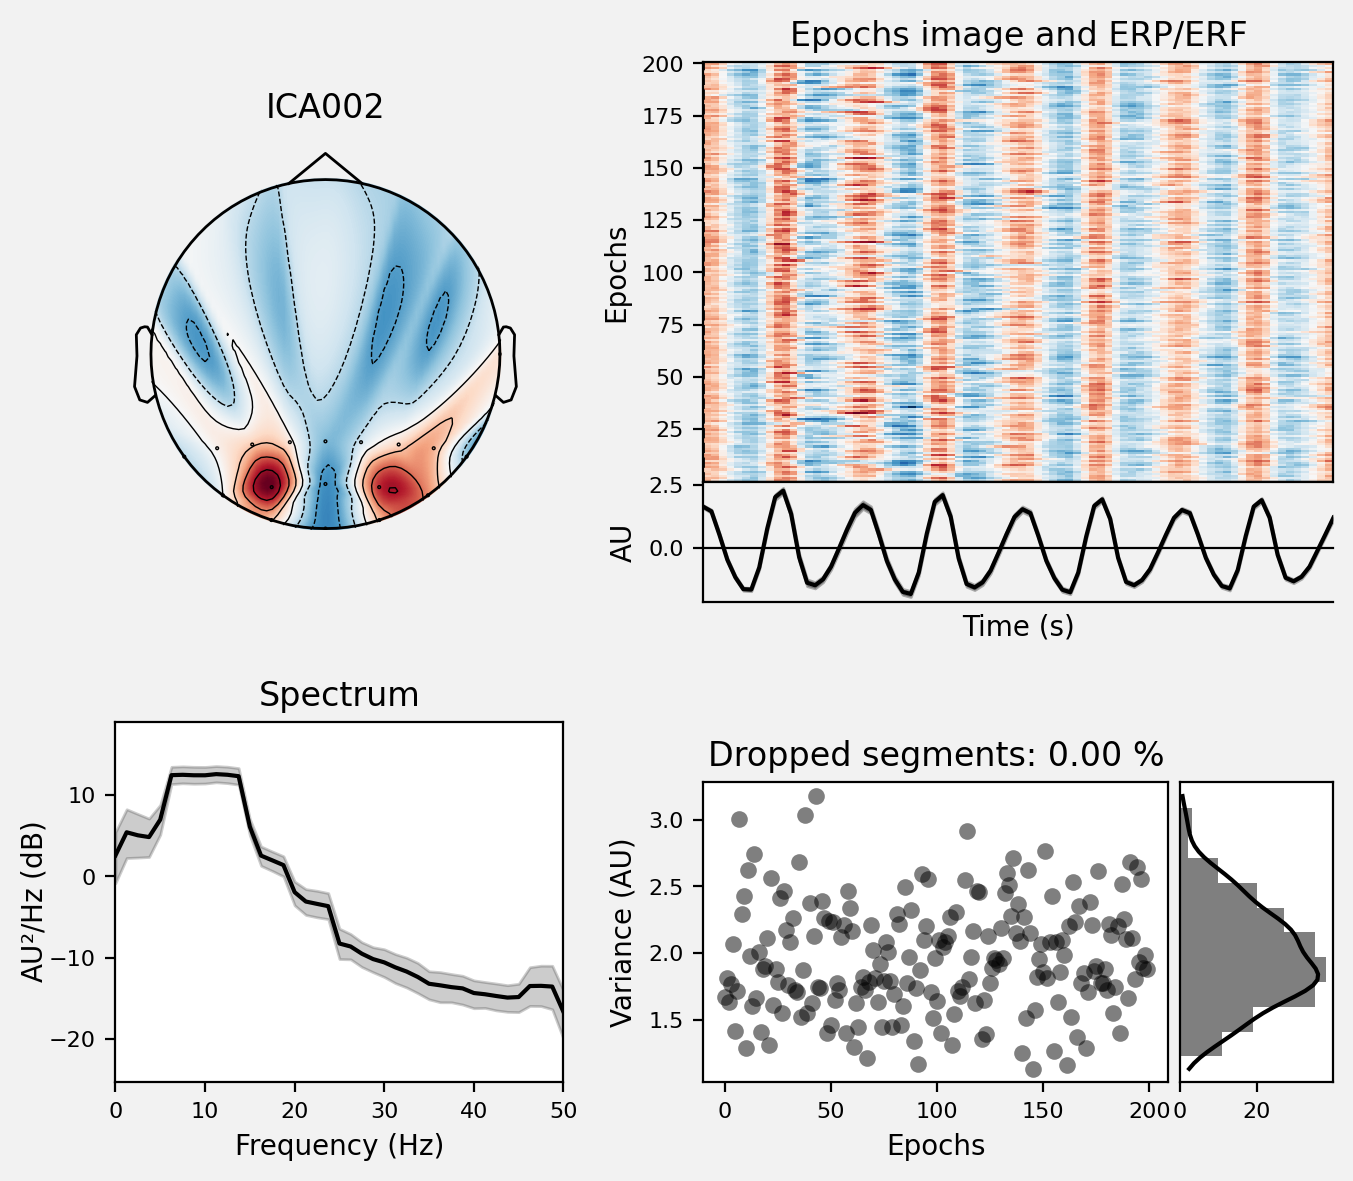

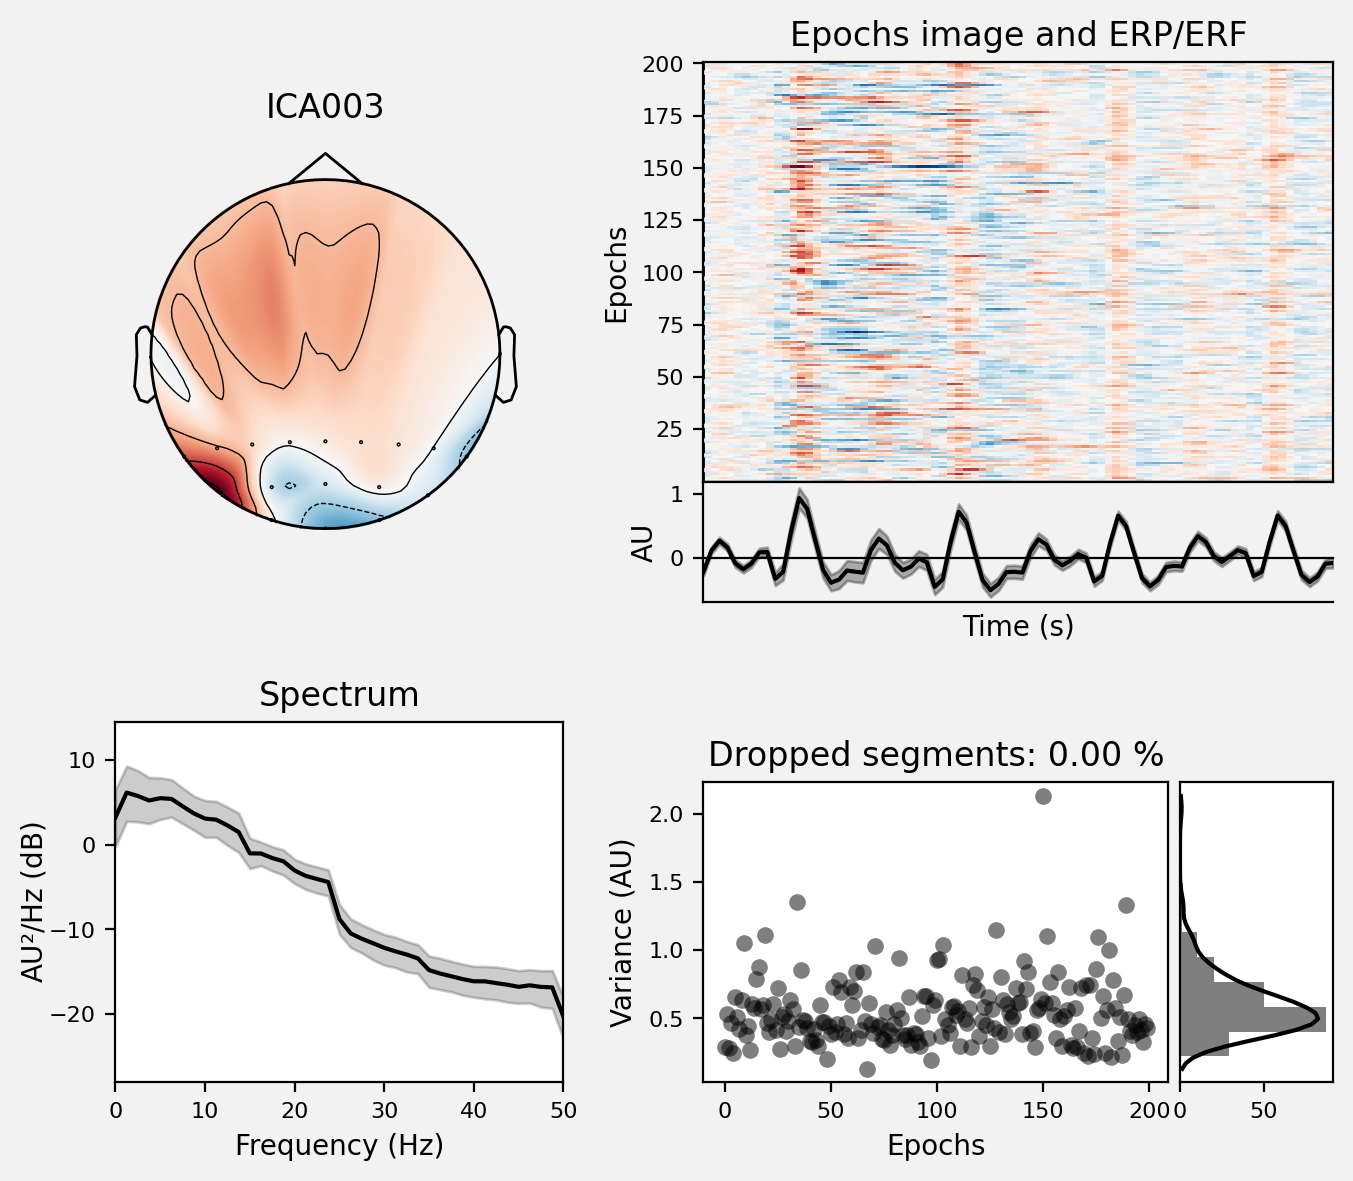

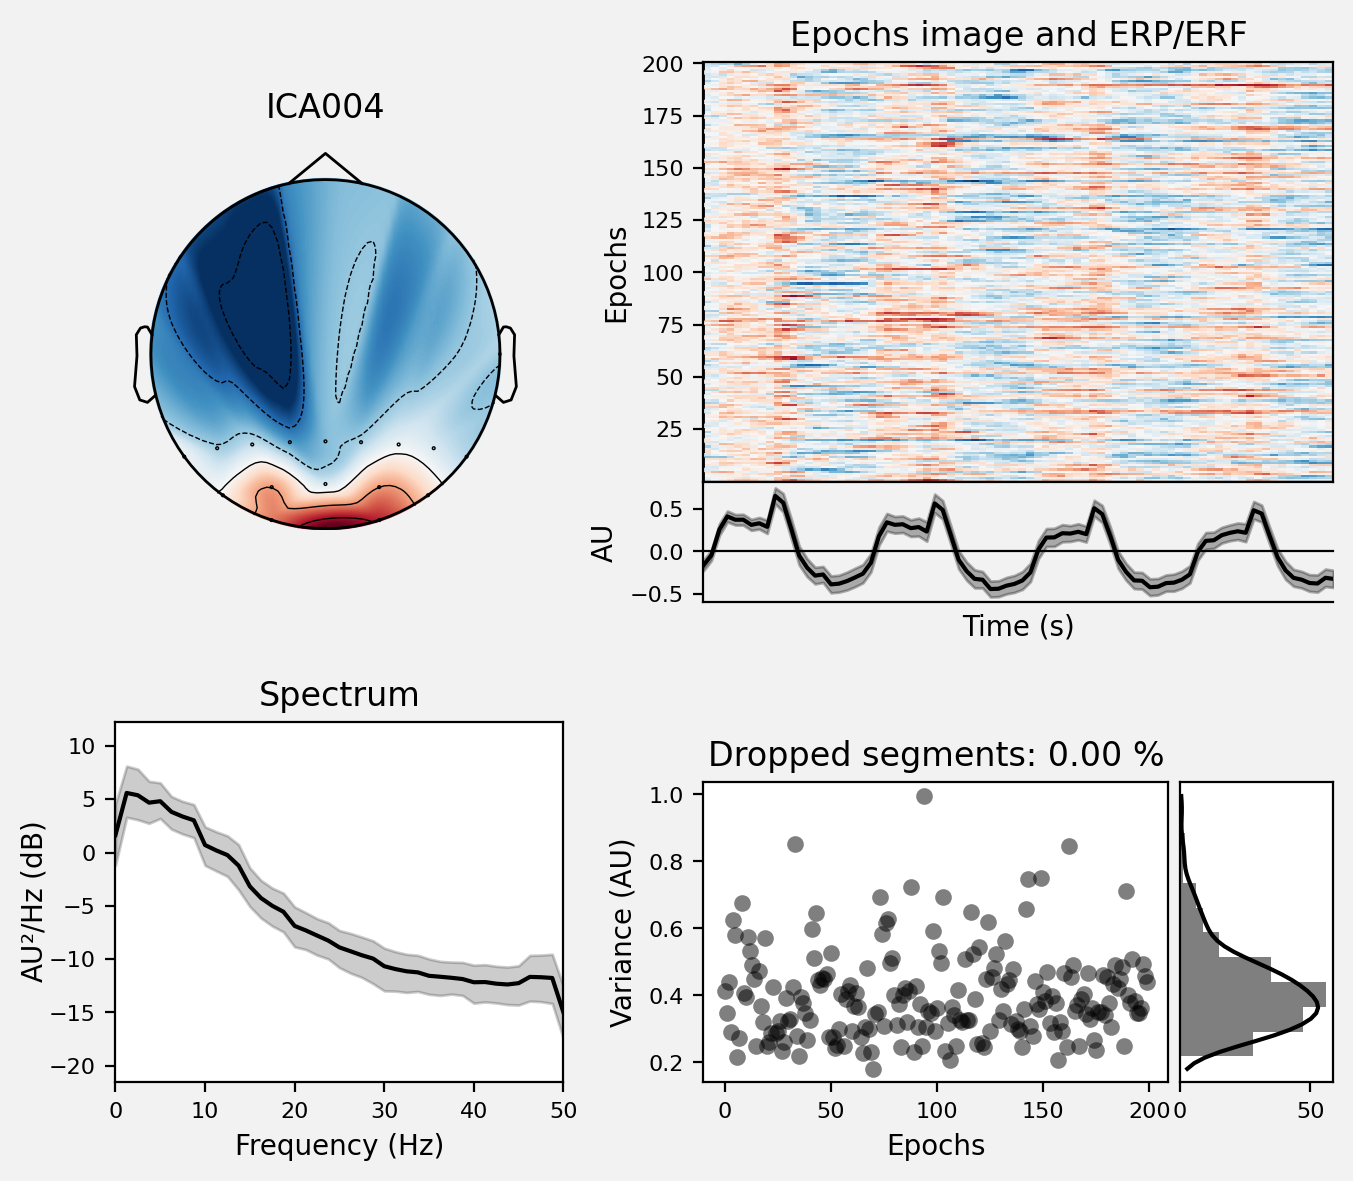

In [14]:
ica.plot_properties(test_epochs);

In [15]:
eog_inds = ica.find_bads_muscle(test_epochs, threshold=4, verbose=False)[0]
eog_inds

[]

In [16]:
ica.get_sources(test_epochs).get_data().shape

/tmp/ipykernel_2612010/2003377691.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  ica.get_sources(test_epochs).get_data().shape


(200, 17, 80)

In [17]:
ica.get_explained_variance_ratio(test_epochs, components=range(1))['eeg']

-0.005828705519290267

In [18]:
variance_ratios = []
variance_explained = []
for i in range(1, 17):
    variance_ratios.append(ica.get_explained_variance_ratio(test_epochs, components=range(i))['eeg'])
    variance_explained.append(ica.get_explained_variance_ratio(test_epochs, components=i-1)['eeg'])
# ica.get_explained_variance_ratio(test_epochs, components=range(8))

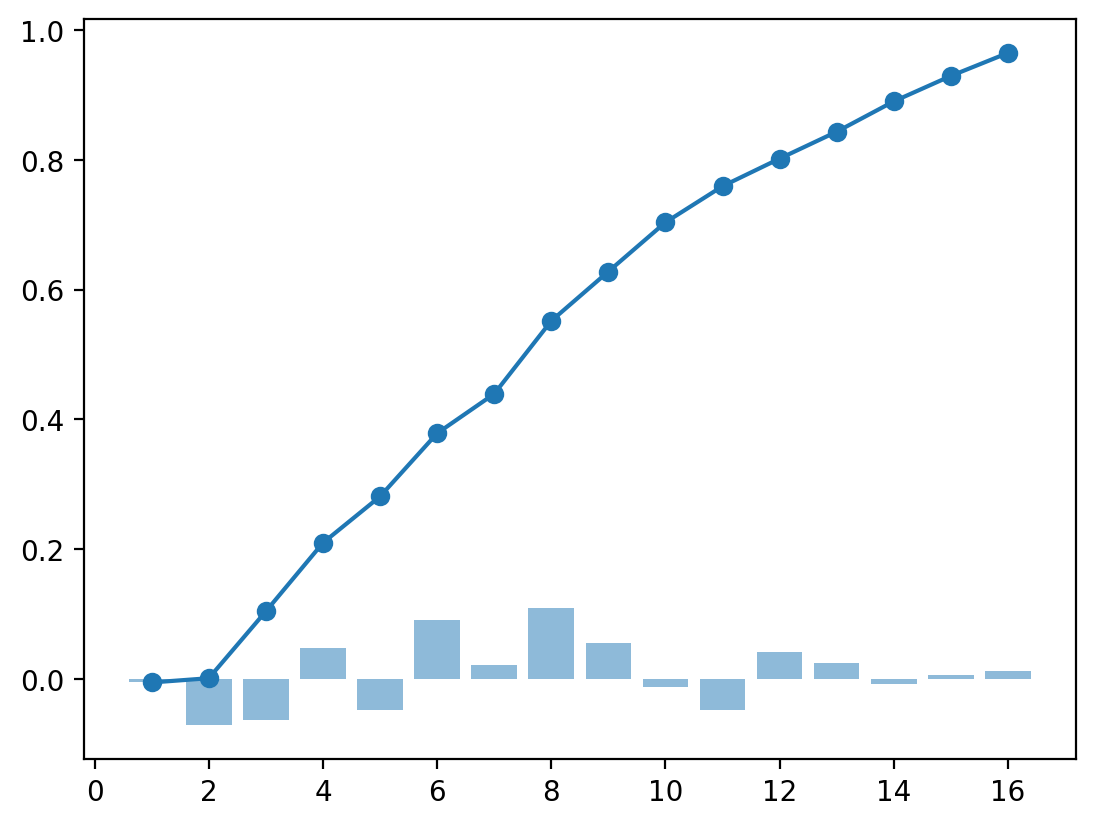

In [19]:
plt.plot(range(1, 17), variance_ratios, marker='o');
plt.bar(range(1, 17), variance_explained, alpha=0.5);
plt.show();

In [26]:
test_epochs_1 = test_epochs.copy()
test_epochs_2 = test_epochs.copy()
test_epochs_3 = test_epochs.copy()
test_epochs_4 = test_epochs.copy()
test_epochs_5 = test_epochs.copy()
test_epochs_6 = test_epochs.copy()
test_epochs_7 = test_epochs.copy()
test_epochs_8 = test_epochs.copy()
test_epochs_9 = test_epochs.copy()
test_epochs_10 = test_epochs.copy()
test_epochs_11 = test_epochs.copy()
test_epochs_12 = test_epochs.copy()
test_epochs_13 = test_epochs.copy()
test_epochs_14 = test_epochs.copy()
test_epochs_15 = test_epochs.copy()
test_epochs_16 = test_epochs.copy()
test_epochs_17 = test_epochs.copy()
ica.apply(test_epochs_1, include=[0])
ica.apply(test_epochs_2, include=[0, 1])
ica.apply(test_epochs_3, include=[0, 1, 2])
ica.apply(test_epochs_4, include=[0, 1, 2, 3])
ica.apply(test_epochs_5, include=[0, 1, 2, 3, 4])
ica.apply(test_epochs_6, include=[0, 1, 2, 3, 4, 5])
ica.apply(test_epochs_7, include=[0, 1, 2, 3, 4, 5, 6])
ica.apply(test_epochs_8, include=[0, 1, 2, 3, 4, 5, 6, 7])
ica.apply(test_epochs_9, include=[0, 1, 2, 3, 4, 5, 6, 7, 8])
ica.apply(test_epochs_10, include=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ica.apply(test_epochs_11, include=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ica.apply(test_epochs_12, include=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ica.apply(test_epochs_13, include=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ica.apply(test_epochs_14, include=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
ica.apply(test_epochs_15, include=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
ica.apply(test_epochs_16, include=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
ica.apply(test_epochs_17, include=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

Applying ICA to Epochs instance
    Transforming to ICA space (17 components)
    Zeroing out 16 ICA components
    Projecting back using 17 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (17 components)
    Zeroing out 15 ICA components
    Projecting back using 17 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (17 components)
    Zeroing out 14 ICA components
    Projecting back using 17 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (17 components)
    Zeroing out 13 ICA components
    Projecting back using 17 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (17 components)
    Zeroing out 12 ICA components
    Projecting back using 17 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (17 components)
    Zeroing out 11 ICA components
    Projecting back using 17 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (1

<EpochsArray |  200 events (all good), 0 – 0.79 s, baseline off, ~2.1 MB, data loaded,
 '1': 200>

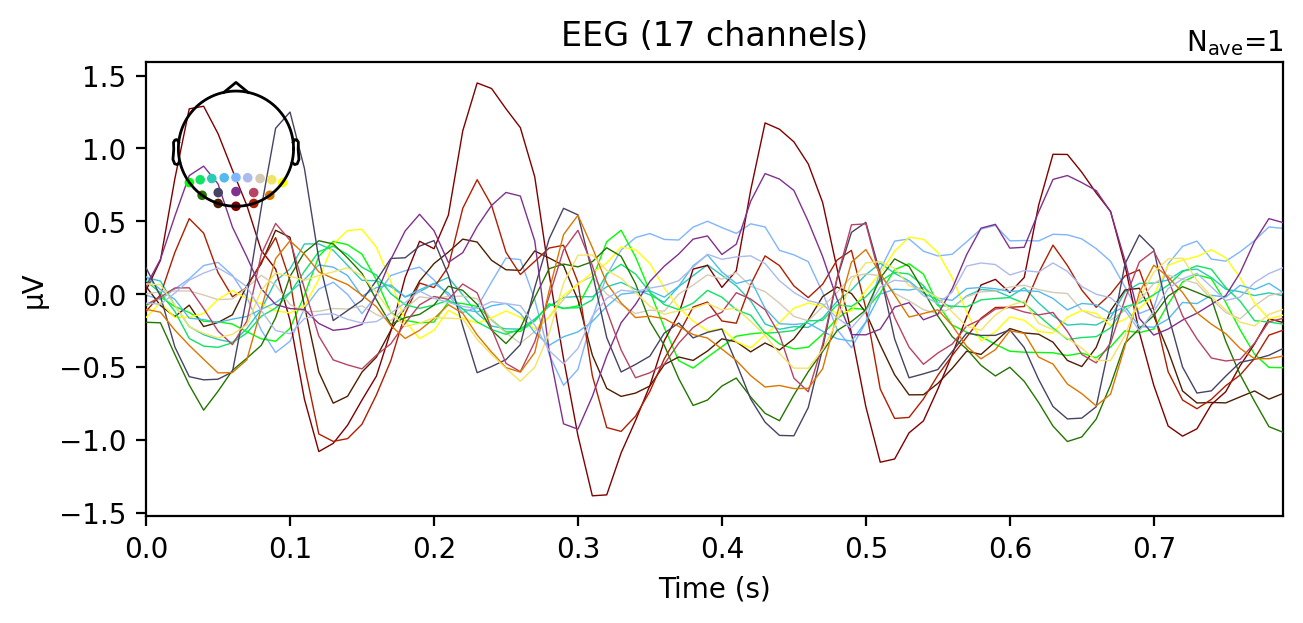

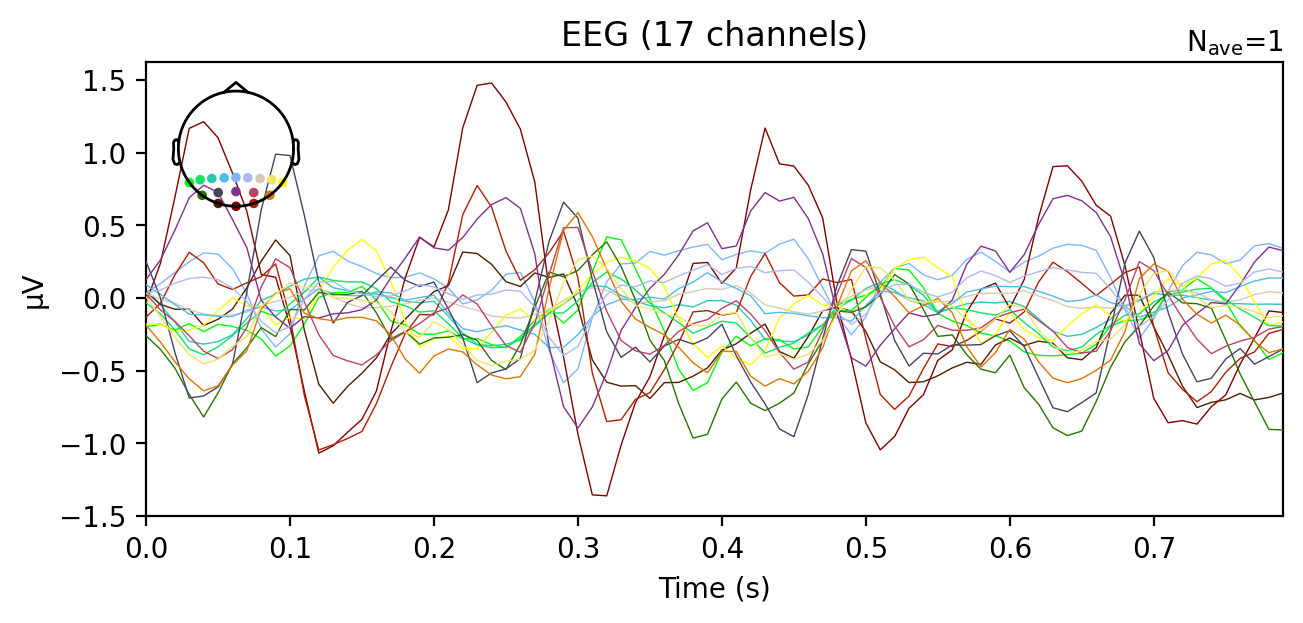

In [21]:
test_epochs[0].average().plot();
test_epochs_8[0].average().plot();

In [22]:
test_epochs_8.get_data().shape

/tmp/ipykernel_2612010/1553466266.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  test_epochs_8.get_data().shape


(200, 17, 80)

In [27]:
dir = '../cache/thingseeg2_synthetic/'
if not os.path.exists(dir):
   os.makedirs(dir)
np.save(dir + 'sub01_ica1_800ms.npy', test_epochs_1.get_data() * 1e6)
np.save(dir + 'sub01_ica2_800ms.npy', test_epochs_2.get_data() * 1e6)
np.save(dir + 'sub01_ica3_800ms.npy', test_epochs_3.get_data() * 1e6)
np.save(dir + 'sub01_ica4_800ms.npy', test_epochs_4.get_data() * 1e6)
np.save(dir + 'sub01_ica5_800ms.npy', test_epochs_5.get_data() * 1e6)
np.save(dir + 'sub01_ica6_800ms.npy', test_epochs_6.get_data() * 1e6)
np.save(dir + 'sub01_ica7_800ms.npy', test_epochs_7.get_data() * 1e6)
np.save(dir + 'sub01_ica8_800ms.npy', test_epochs_8.get_data() * 1e6)
np.save(dir + 'sub01_ica9_800ms.npy', test_epochs_9.get_data() * 1e6)
np.save(dir + 'sub01_ica10_800ms.npy', test_epochs_10.get_data() * 1e6)
np.save(dir + 'sub01_ica11_800ms.npy', test_epochs_11.get_data() * 1e6)
np.save(dir + 'sub01_ica12_800ms.npy', test_epochs_12.get_data() * 1e6)
np.save(dir + 'sub01_ica13_800ms.npy', test_epochs_13.get_data() * 1e6)
np.save(dir + 'sub01_ica14_800ms.npy', test_epochs_14.get_data() * 1e6)
np.save(dir + 'sub01_ica15_800ms.npy', test_epochs_15.get_data() * 1e6)
np.save(dir + 'sub01_ica16_800ms.npy', test_epochs_16.get_data() * 1e6)
np.save(dir + 'sub01_ica17_800ms.npy', test_epochs_17.get_data() * 1e6)

/tmp/ipykernel_2612010/1209501169.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  np.save(dir + 'sub01_ica1_800ms.npy', test_epochs_1.get_data() * 1e6)
/tmp/ipykernel_2612010/1209501169.py:5: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  np.save(dir + 'sub01_ica2_800ms.npy', test_epochs_2.get_data() * 1e6)
/tmp/ipykernel_2612010/1209501169.py:6: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  np.save(dir + 'sub01_ica3_800ms.npy', test_epochs_3.get_data() * 1e6)
/tmp/ipykernel_2612010/1209501169.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  np.save(dir + 'sub01_ica4_800ms.npy', test_epochs_4.get_data() * 1e6)
/tmp